In [1]:
import sys
sys.path.append('../30_data_tools/')

In [2]:
import plotly.express as px
import json
from datetime import datetime
import pandas as pd

In [3]:
from file_interaction import download_blob, get_blobs
import plotly.graph_objects as go

In [38]:
available_experiments = get_blobs(filter='train_logs/')
available_experiments[-10:]

['train_logs/2024-05-04_MobileNetV3_001.json',
 'train_logs/2024-05-04_Resnet50_001.json',
 'train_logs/2024-05-04_Resnet50_002.json',
 'train_logs/2024-05-09_Resnet50_001.json',
 'train_logs/2024-05-09_Resnet50_002.json',
 'train_logs/2024-05-10_Resnet50_001.json',
 'train_logs/2024-05-10_Resnet50_002.json',
 'train_logs/2024-05-10_Resnet50_003.json',
 'train_logs/2024-05-10_Resnet50_004.json',
 'train_logs/2024-05-10_Resnet50_005.json']

In [5]:
def load_experiment( experiment_name ):
    json_buffer = download_blob( f'train_logs/{ experiment_name }.json' )
    data = json.loads( json_buffer.getvalue() )
    data['start_timestamp'] = datetime.fromisoformat(data['start_timestamp'])

    if 'end_timestamp' in data:
        data['end_timestamp'] = datetime.fromisoformat(data['end_timestamp'])

    for t in data['tracked_metrics']:
        t['timestamp'] = datetime.fromisoformat(t['timestamp'])
        t['value'] = float(t['value'])
    
    return data

In [6]:
def get_metric_figure( data, metric_name='loss' ):
    fig = go.Figure()
    max_step = data.loc[data.metric_name == metric_name].step.max()

    for dataset in data.dataset.unique():
        selection = data.loc[
            (data.metric_name == metric_name) &
            (data.dataset == dataset)
        ]
        step_size = max_step / selection.step.max()
        
        keys = round(selection.step * step_size + (selection.epoch - 1) * step_size * selection.step.max()).to_numpy()
        
        values = data.loc[
            (data.metric_name == metric_name) &
            (data.dataset == dataset)
        ].value.to_numpy()

        fig.add_trace(go.Scatter(
            x=keys, #[i for i in range(values.shape[0])],
            y=values,
            mode="lines",
            name=dataset
        ))
    
    fig.update_layout(yaxis_range=[0,1])
    fig.update_layout(legend={'orientation':'h'})

    return fig

In [7]:
def get_figure( data, metric_name, mode ):
    fig = px.line(
        x=data.loc[(data.metric_name == metric_name) &  (data['mode'] == mode)].step,
        y=data.loc[(data.metric_name == metric_name) &  (data['mode'] == mode)].value,
        color=data.loc[(data.metric_name == metric_name) &  (data['mode'] == mode)].epoch
    )
    #fig.update_layout(yaxis_range=[0,1])
    
    return fig

In [ ]:
get_metric_figure( data )

In [39]:
experiment_name = '2024-05-10_Resnet50_005'
experiment_data = load_experiment( experiment_name )
data = pd.DataFrame.from_dict(experiment_data['tracked_metrics'])

In [40]:
experiment_data['hyper_parameters']

{'dataset_name': '24-05-09_001_tile_dataset',
 'data_type': 'frequency',
 'epochs': 10,
 'learning_rate': 0.001,
 'batch_size': 64,
 'loss_function': 'CrossEntropyLoss',
 'metric_functions': ['MulticlassAccuracy',
  'MulticlassRecall',
  'MulticlassPrecision'],
 'optimizer': 'adam',
 'device': 'cuda'}

In [41]:
data.loc[
    data.metric_name == 'loss'
].groupby([
    'dataset',
    'epoch'
]).mean()

/var/folders/ns/b_3z05zx1bz71dzh3qcvtpyh0000gq/T/ipykernel_92144/3992092918.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



value        step
dataset  epoch                      
real_val 1      0.659374    5.416667
train    1      0.487463  101.995122
         2      0.461013   18.500000
val      1      0.525707   11.458333

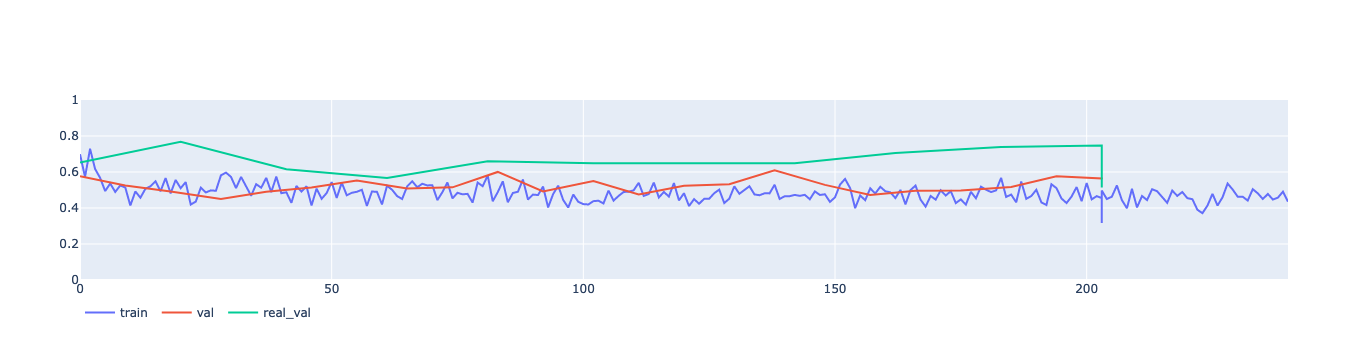

In [42]:
get_metric_figure( data )

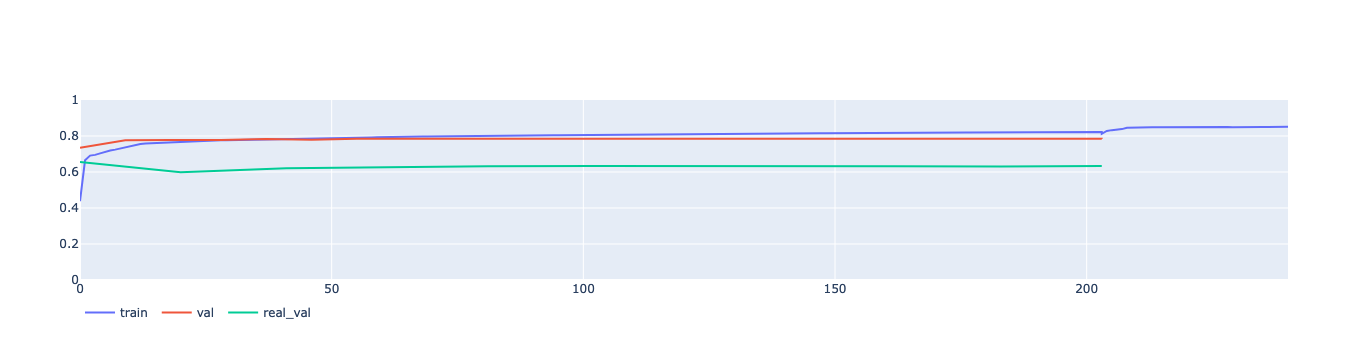

In [43]:
get_metric_figure( data, metric_name='accuracy' )

In [ ]:
px.scatter(
    x=[i for i in range(data.loc[(data.dataset == 'train') & (data.metric_name == 'loss')].shape[0])],
    y=data.loc[(data.dataset == 'train') & (data.metric_name == 'loss')].value,
    trendline="ols"
)

In [ ]:
px.scatter(
    x=[i for i in range(data.loc[(data.dataset == 'val') & (data.metric_name == 'loss')].shape[0])],
    y=data.loc[(data.dataset == 'val') & (data.metric_name == 'loss')].value,
    trendline="ols"
)

In [ ]:
px.scatter(
    x=[(i+1) for i in range(data.loc[(data.dataset == 'real_val') & (data.metric_name == 'loss')].shape[0])],
    y=data.loc[(data.dataset == 'real_val') & (data.metric_name == 'loss')].value,
    trendline="ols",
    #trendline_options=dict(log_x=True)
)

In [ ]:
rel_data_train = data.loc[data['mode'] == 'train'].copy()
rel_data_train.loc[:,'step_total'] = (rel_data_train.epoch - 1) * rel_data_train.step.max() + rel_data_train.step

grouped_train = rel_data_train.loc[
    :,
    ['metric_name','step_total','value']
].groupby(['metric_name','step_total']).first().unstack('metric_name')

grouped_train.columns = [c[1] for c in grouped_train.columns]

In [ ]:
px.line(
    grouped_train
)

In [ ]:
rel_data_val = data.loc[data['mode'] == 'val'].copy()
rel_data_val.loc[:,'step_total'] = (rel_data_val.epoch - 1) * rel_data_val.step.max() + rel_data_val.step

grouped_val = rel_data_val.loc[
    :,
    ['metric_name','step_total','value']
].groupby(['metric_name','step_total']).first().unstack('metric_name')

grouped_val.columns = [c[1] for c in grouped_val.columns]

In [ ]:
(grouped_val.loss.iloc[-1] - grouped_val.loss.iloc[0]) / grouped_val.shape[0]

In [ ]:
px.line(
    grouped_val
)

In [ ]:
get_figure(
    data,
    'loss',
    'train'
)

In [ ]:
get_figure(
    data,
    'loss',
    'val'
)

In [ ]:
get_figure(
    data,
    'accuracy',
    'val'
)

In [ ]:
get_figure(
    data,
    'recall',
    'val'
)

In [ ]:
get_figure(
    data,
    'precision',
    'val'
)